In [1]:
import os
import datetime as dt

import pandas as pd
import torch
from torch.utils.data import DataLoader
from torchvision import models,transforms
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np

from dataset import MaskDataset, TestDataset, label_decoder
from models import get_pre_trained

In [2]:
def load_model(model_name, model_path, num_classes, device):
    model = get_pre_trained(model_name, pretrained = False)
    model_path = os.path.join(model_path, f'{model_name}/{model_name}_best.pt')
    model.load_state_dict(torch.load(model_path, map_location=device))
    print('load_state_dict completed')
    return model

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model_name = 'densenet161'
# model_name = 'resnet50'
num_classes = 18
model_path = f'../model'
model = load_model(model_name, model_path, num_classes, device).to(device)
model.eval()

load_state_dict completed


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [4]:
data_dir = '../../input/data/eval'
img_root = os.path.join(data_dir, 'images')
info_path = os.path.join(data_dir, 'info.csv')
info = pd.read_csv(info_path)

img_paths = [os.path.join(img_root, img_id) for img_id in info.ImageID]

In [5]:
mean=(0.485, 0.456, 0.406); std=(0.229, 0.224, 0.225)
val_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean, std)])

test_dataset = TestDataset(img_paths=img_paths,transforms=val_transform)

In [6]:
test_loader = DataLoader(
        test_dataset,
        batch_size=16,
        shuffle=False,
        pin_memory=use_cuda,
        drop_last=False,
    )

In [7]:
print("Calculating inference results..")
output_dir = '../output'
now = dt.datetime.now() 
formattedDate = now.strftime("%m%d_%H시%M분")
preds = []
with torch.no_grad():
    for idx, images in enumerate(tbar := tqdm(test_loader)):
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        preds.extend(pred.cpu().numpy())

info['ans'] = preds
save_path = os.path.join(output_dir, f'{model_name}_{formattedDate}.csv')
info.to_csv(save_path, index=False)
print(f"Inference Done! Inference result saved at {save_path}")


Calculating inference results..


100%|██████████| 788/788 [03:05<00:00,  4.24it/s]

Inference Done! Inference result saved at ../output/densenet161_0224_14시34분.csv


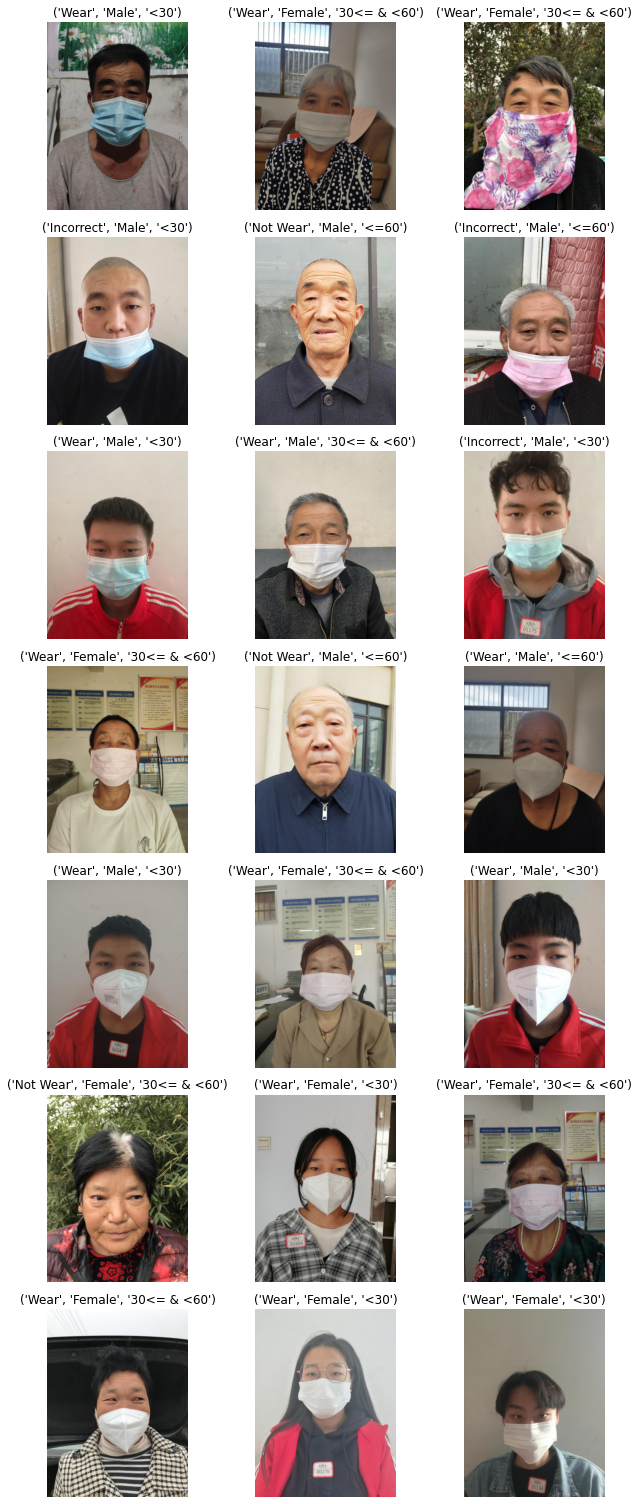

In [12]:
N = 21

fig, ax = plt.subplots(N//3, 3, figsize=(3*3, N))
idxs = np.random.choice(len(info), N)
ax = ax.flatten()
for idx, data_idx in enumerate(idxs):
    pred = info['ans'].iloc[data_idx]
    image_path = f"{data_dir}/images/{info['ImageID'].iloc[data_idx]}"
    image = plt.imread(image_path)
    
    pred = label_decoder(pred)
    ax[idx].set_title(f'{pred}')
    ax[idx].imshow(image)
    ax[idx].axis('off')

plt.tight_layout()